#1. Loading Data and Libraries

1.1 Loding Libraries

In [ ]:
!pip install scikit-learn==1.3.1
!pip install tensorflow
!pip install keras-tuner
!pip install shap
!pip install xgboost
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras_tuner as kt
import shap

1.2 Loading Data

In [ ]:
# Loading datasets
train_data_FD001 = pd.read_csv("/train_FD001.txt", sep="\s+", header=None)
test_data_FD001 = pd.read_csv("/test_FD001.txt", sep="\s+", header=None)
rul_data_FD001 = pd.read_csv("/RUL_FD001.txt", sep="\s+", header=None)

# Assigning column names for clarity
column_names = ["engine_id", "cycle", "operational_setting_1", "operational_setting_2",
                "operational_setting_3"] + [f"sensor_{i}" for i in range(1, 22)]
train_data_FD001.columns, test_data_FD001.columns = column_names, column_names

In [ ]:
train_data_FD001

,engine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [ ]:
test_data_FD001

,engine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [ ]:
rul_data_FD001

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


# 2. Data Preprocessing

In [ ]:
# Calculating Remaining Useful Life (RUL) in cycles
# Getting max cycle per engine
max_cycle = train_data_FD001.groupby('engine_id')['cycle'].max().reset_index()
max_cycle.columns = ['engine_id', 'max_cycle']

# Merging with the original dataframe
train_data_FD001 = train_data_FD001.merge(max_cycle, on='engine_id', how='left')

# Calculating RUL: difference between max cycle and current cycle
train_data_FD001['RUL'] = train_data_FD001['max_cycle'] - train_data_FD001['cycle']

# Dropping the max_cycle column as it's no longer needed
train_data_FD001.drop('max_cycle', axis=1, inplace=True)

In [ ]:
train_data_FD001

,engine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [ ]:
print(train_data_FD001[['engine_id', 'cycle', 'RUL']].head())

   engine_id  cycle  RUL
0          1      1  191
1          1      2  190
2          1      3  189
3          1      4  188
4          1      5  187


Shape of training data: (20631, 27)
Shape of testing data: (13096, 26)


<Axes: >

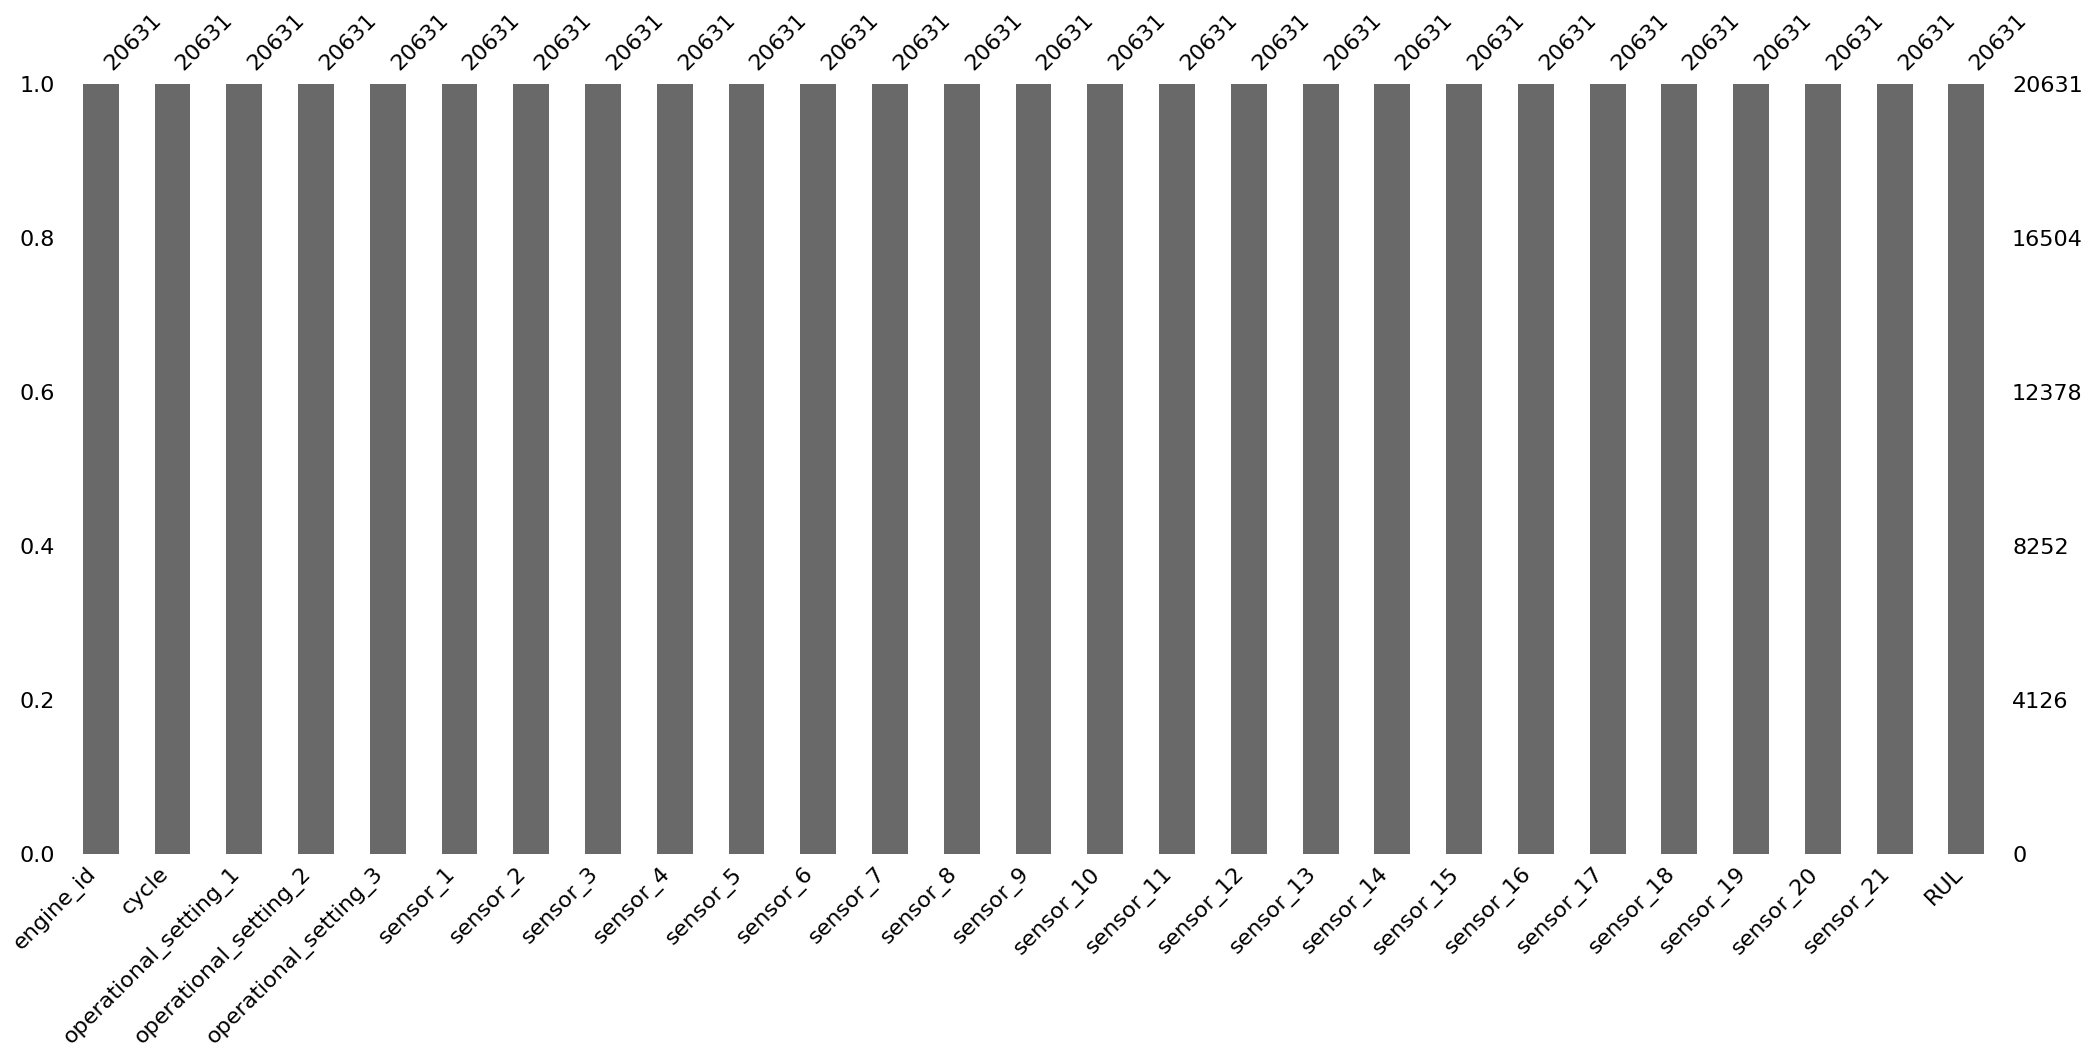

In [ ]:
# Checking the shape of the data
print("Shape of training data:", train_data_FD001.shape)
print("Shape of testing data:", test_data_FD001.shape)

# Checking for missing values
msno.bar(train_data_FD001)

No missing values found in the train set.

<Axes: >

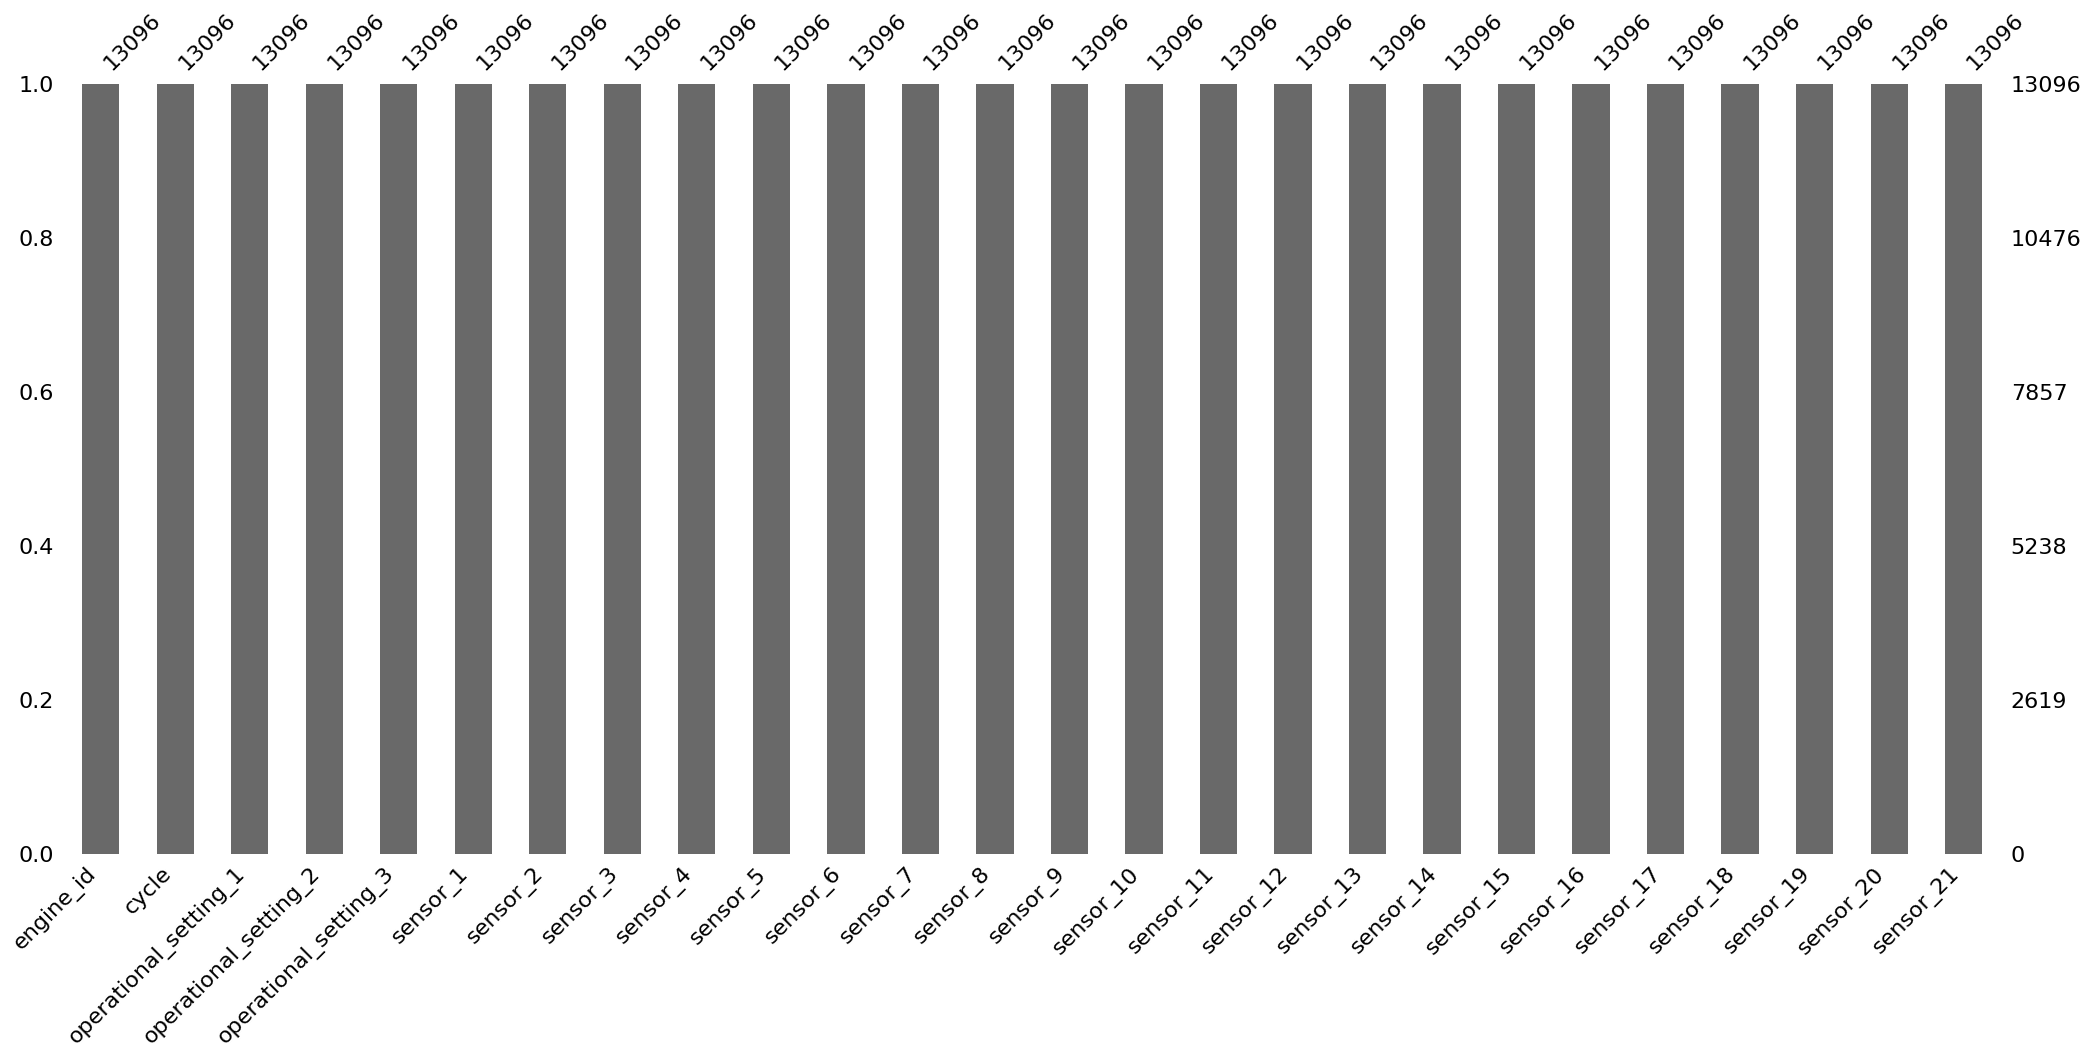

In [ ]:
msno.bar(test_data_FD001)

No missing values found in the test set.

# 3. Exploratory Data Analysis (EDA)

In [ ]:
# Choosing the engines with the longest and shortest RULs
longest_RUL_engines = train_data_FD001.sort_values(by=['RUL'])['engine_id'].value_counts().head(3).index.to_list()
shortest_RUL_engines = train_data_FD001.sort_values(by=['RUL'])['engine_id'].value_counts().tail(3).index.to_list()

engines = sorted(longest_RUL_engines + shortest_RUL_engines)

In [ ]:
for col in [i for i in train_data_FD001.columns if i not in ['engine_id', 'cycle']]:
    plt.figure(figsize=(15, 4))
    sns.lineplot(data=train_data_FD001[train_data_FD001['engine_id'].isin(engines)], x='cycle', y=col, hue='engine_id', palette="flare")
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

          engine_id         cycle  operational_setting_1  \
count  20631.000000  20631.000000           20631.000000   
mean      51.506568    108.807862              -0.000009   
std       29.227633     68.880990               0.002187   
min        1.000000      1.000000              -0.008700   
25%       26.000000     52.000000              -0.001500   
50%       52.000000    104.000000               0.000000   
75%       77.000000    156.000000               0.001500   
max      100.000000    362.000000               0.008700   

       operational_setting_2  operational_setting_3      sensor_1  \
count           20631.000000                20631.0  2.063100e+04   
mean                0.000002                  100.0  5.186700e+02   
std                 0.000293                    0.0  6.537152e-11   
min                -0.000600                  100.0  5.186700e+02   
25%                -0.000200                  100.0  5.186700e+02   
50%                 0.000000                 

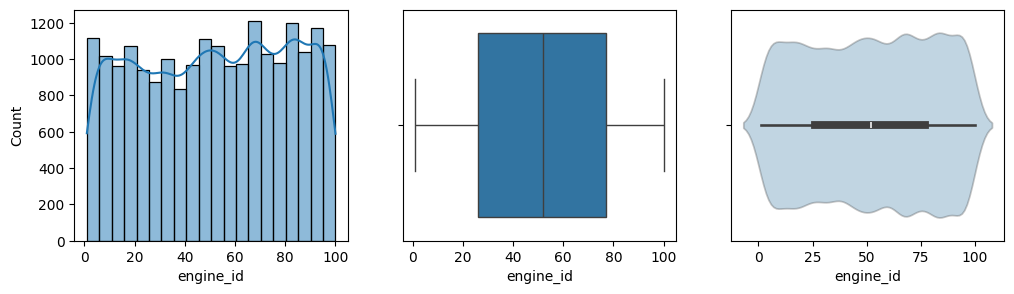

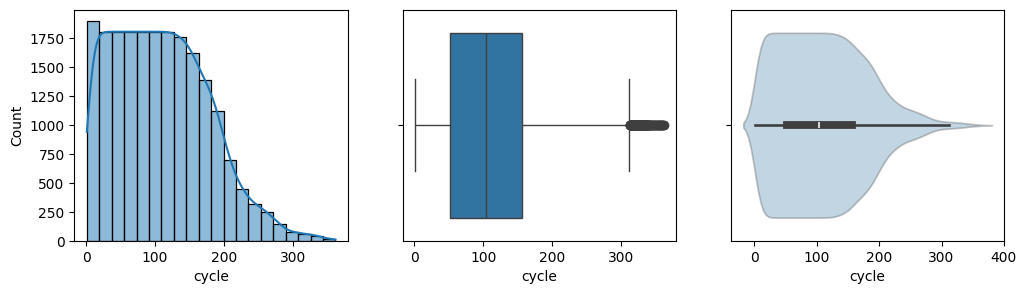

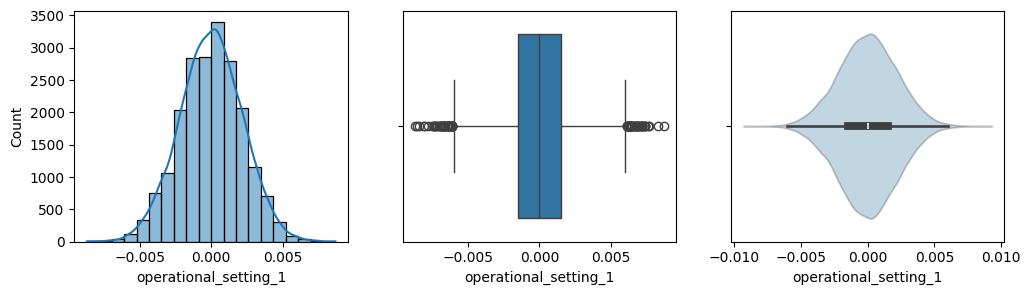

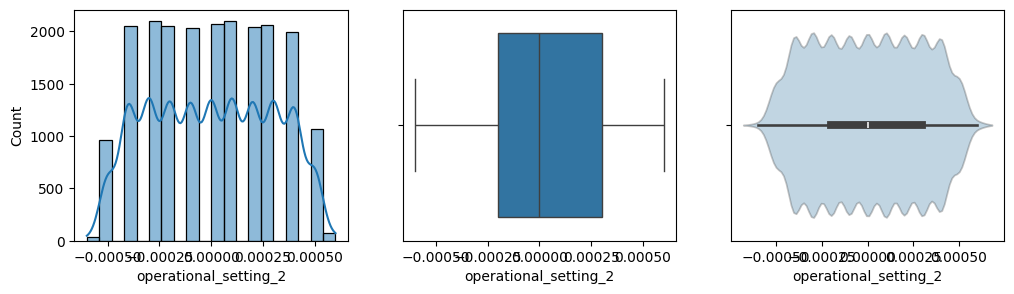

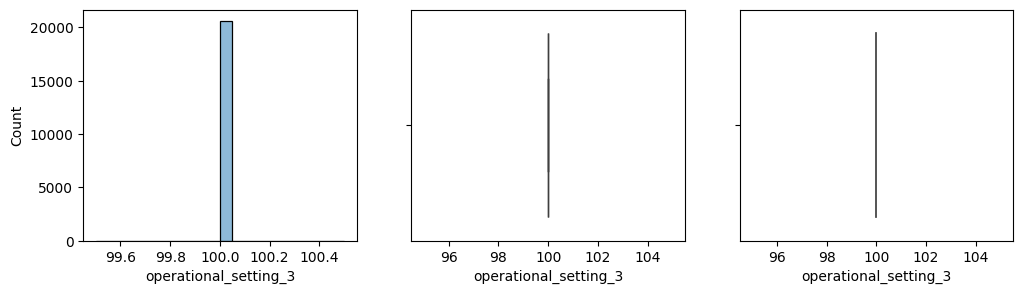

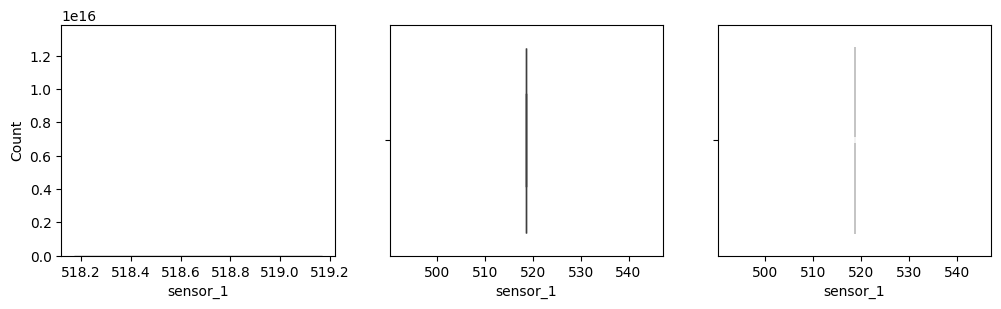

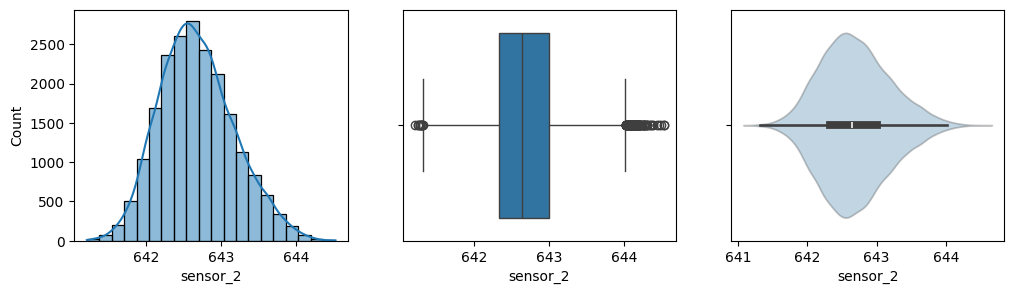

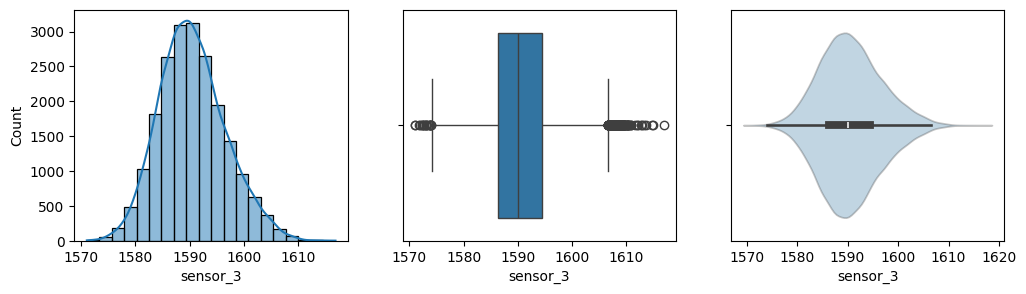

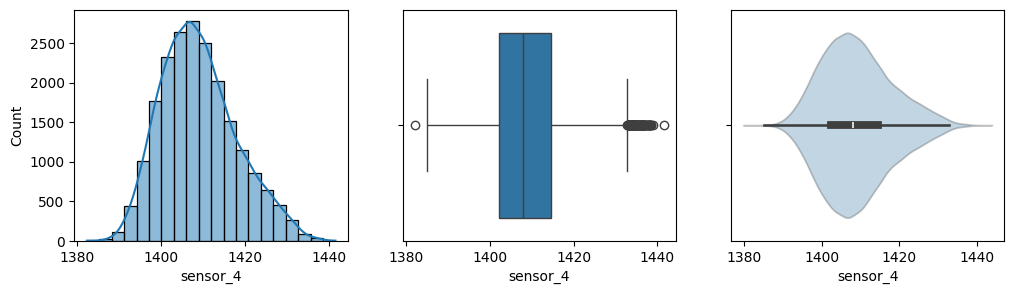

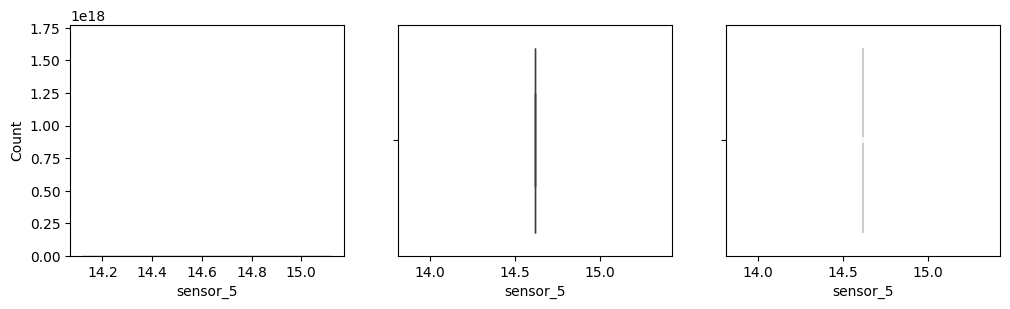

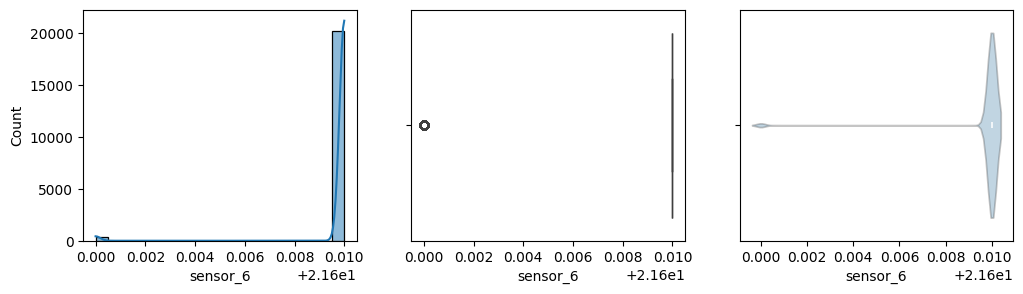

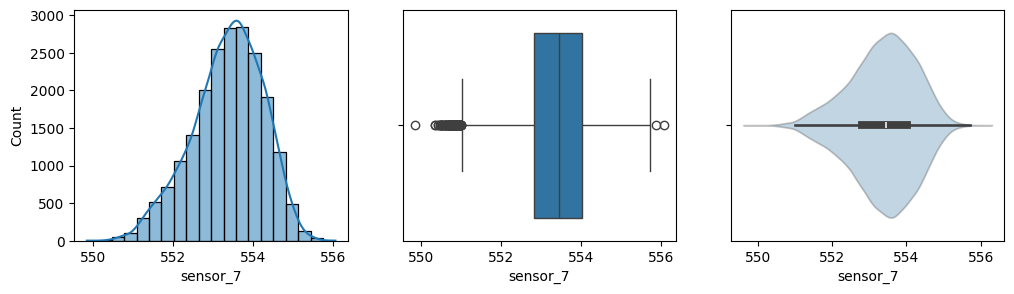

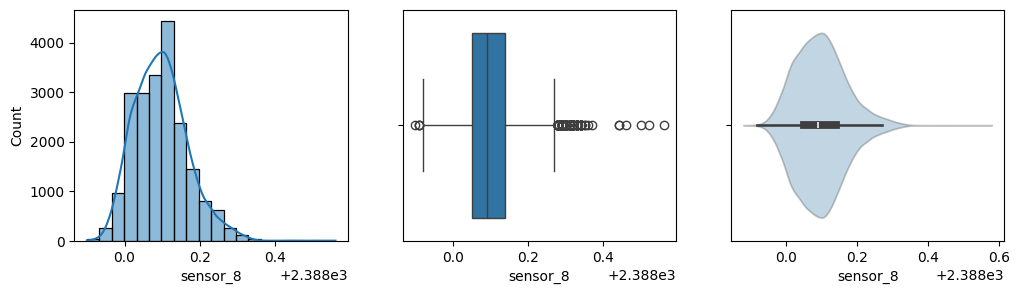

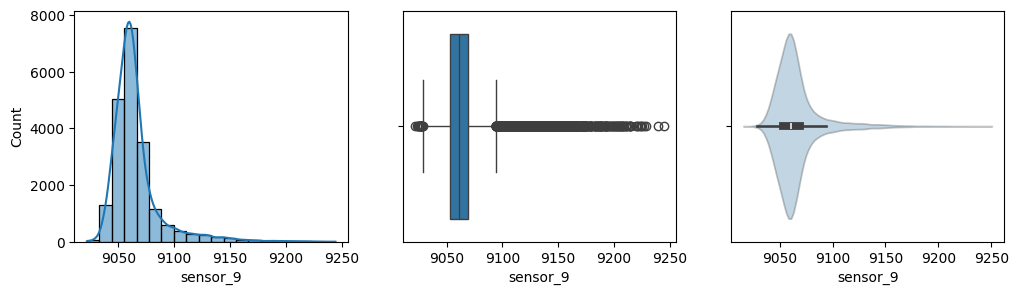

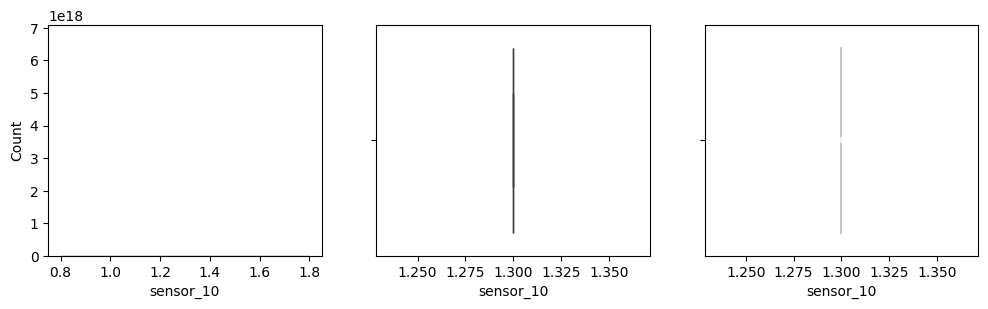

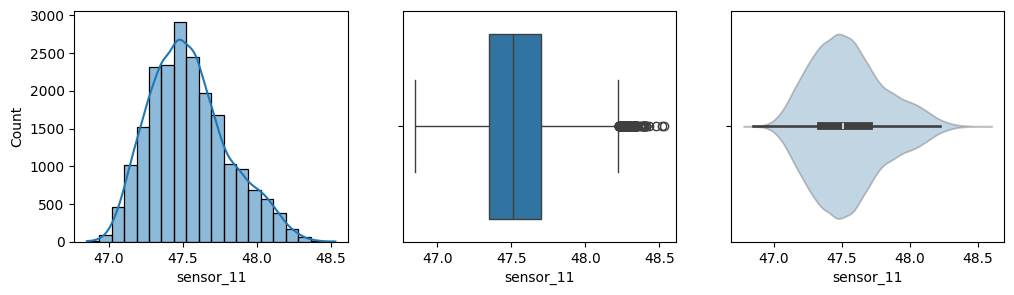

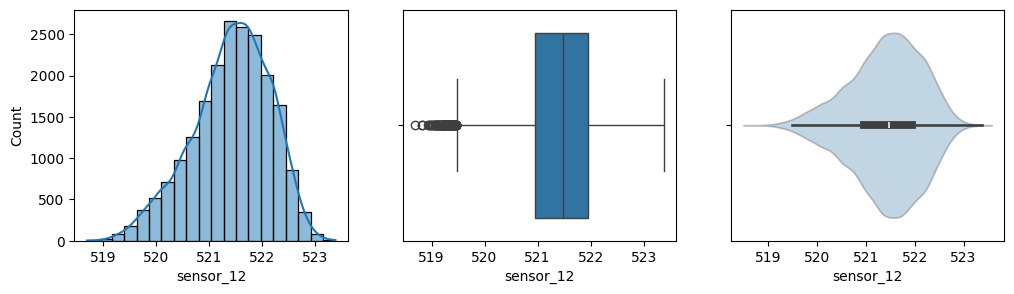

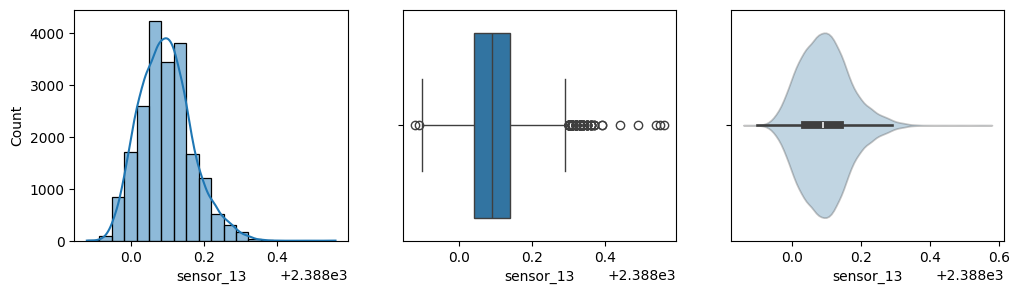

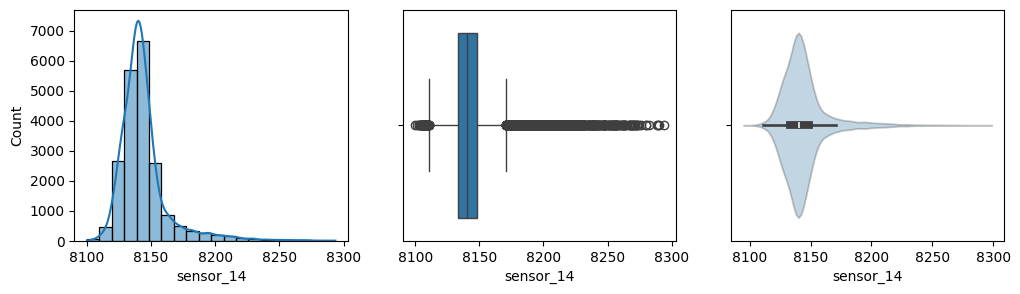

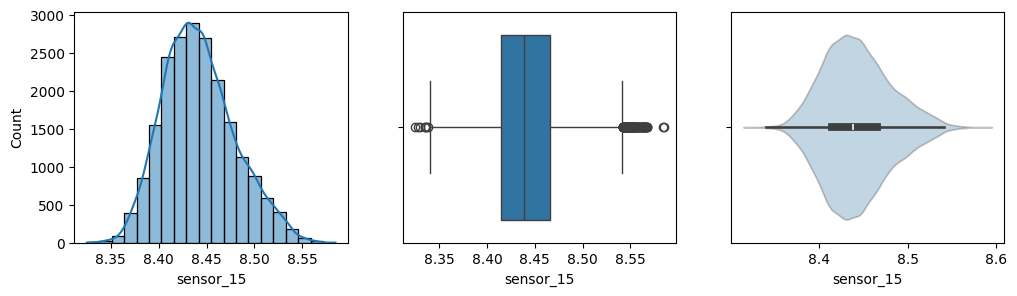

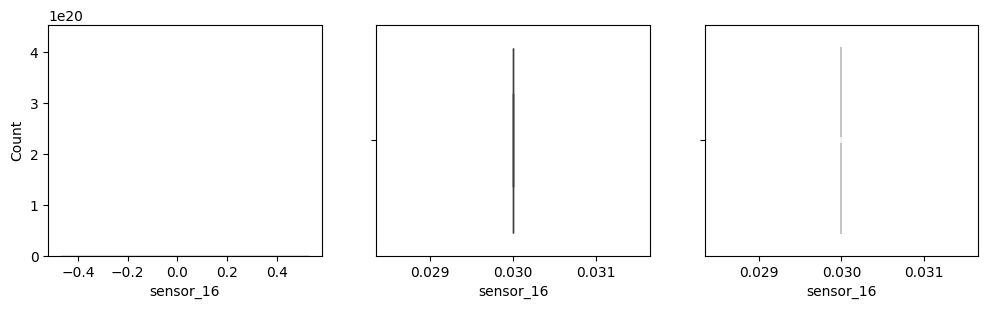

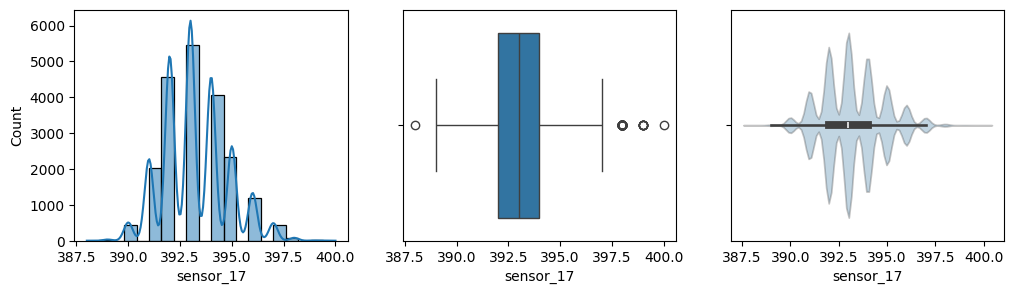

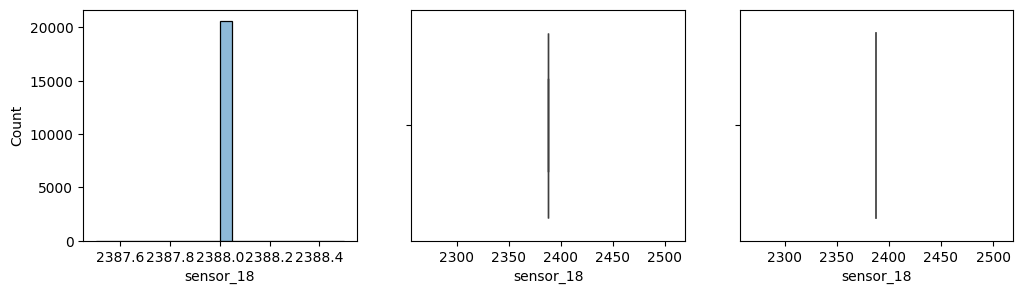

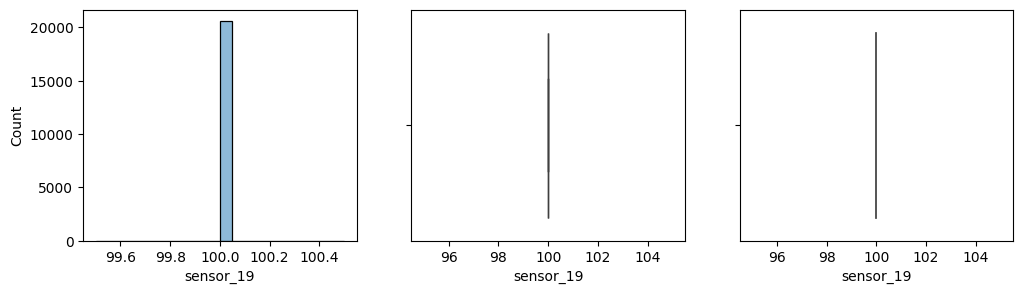

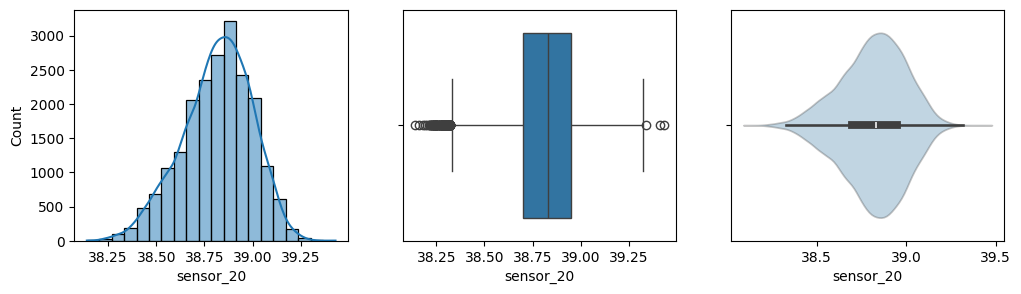

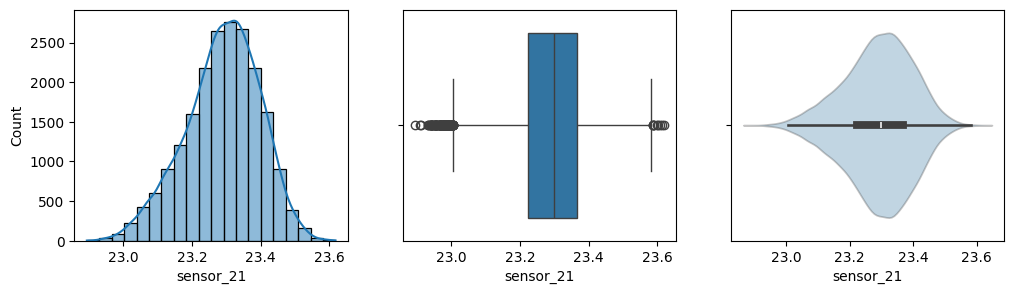

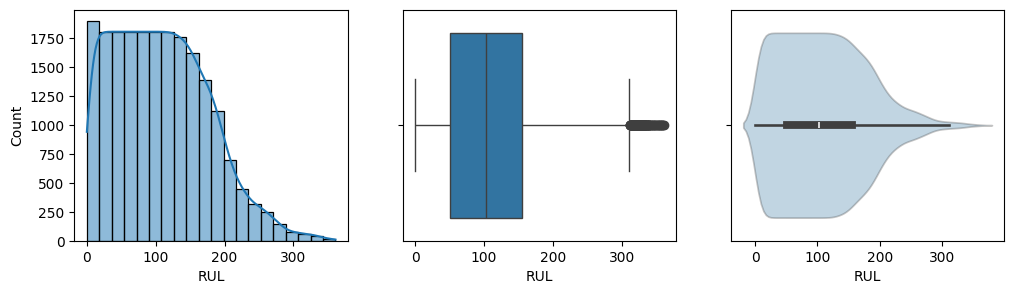

In [ ]:
# Summary statistics for numeric columns
train_stats = train_data_FD001.describe()
print(train_stats)

# Plots for deeper understanding
for col in train_data_FD001.columns:
   f, ax = plt.subplots(1,3,figsize=(12,3))
   sns.histplot(train_data_FD001, x=col, ax=ax[0], kde=True, bins=20, stat='count')
   sns.boxplot(train_data_FD001, x=col, ax=ax[1])
   sns.violinplot(train_data_FD001, x=col, ax=ax[2], alpha=0.3)
   plt.show()

Feature Selection & Engineering

In [ ]:
# Checking standard deviation values (spread/variability check)
train_data_FD001.iloc[:,:-1].std()

,0
engine_id,2.922763e+01
cycle,6.888099e+01
operational_setting_1,2.187313e-03
operational_setting_2,2.930621e-04
operational_setting_3,0.000000e+00
sensor_1,6.537152e-11
sensor_2,5.000533e-01
sensor_3,6.131150e+00
sensor_4,9.000605e+00
sensor_5,3.394700e-12


In [ ]:
# Identifying features with low variance and removing them
low_variance_sensors = train_data_FD001.iloc[:,5:-1].std()[train_data_FD001.iloc[:,5:-1].std() < 0.01].index
print(f"Low variance sensors: {low_variance_sensors}")
train_data_FD001.drop(columns=low_variance_sensors, inplace=True)
test_data_FD001.drop(columns=low_variance_sensors, inplace=True)

Low variance sensors: Index(['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16',
       'sensor_18', 'sensor_19'],
      dtype='object')


sensor_1, sensor_5, sensor_6, sensor_10, sensor_16, sensor_18 and sensor_19 are dropped in the step above because they have very low variance. As they have very low variability and from the histograms it is evident that the values are constant, hence they would not contribute much to the predictive ability of the model and might instead add noise.

From the boxplots it can be observed that many sensors have outliers which lie outside the lower and upper bound. On performing a few trials of model training on a basic linear regression model and evaluating the metrics, it was observed that removing these outliers reduces the model's predictive ability resulting in a lower R-squared score, which would mean that these values consist important information which is valuable for increasing the data variance and moreover the predictive ability of the model.
Furthermore, another approach of capping the values (replacing the outliers with boundary values) was tried which had no impact either on the linear correlations between the features and the target, or on the R-squared score of the model. Hence, it was decided to keep the outliers.

In [ ]:
# Feature Transformation

# Normalization with static mean of first 10 feature values
for sensor in [s for s in train_data_FD001.columns if s.startswith('sensor')]:

    train_data_FD001[f'{sensor}'] = train_data_FD001[sensor] / train_data_FD001.groupby('engine_id')[sensor].transform(lambda x: x.iloc[:10].mean())
    test_data_FD001[f'{sensor}'] = test_data_FD001[sensor] / test_data_FD001.groupby('engine_id')[sensor].transform(lambda x: x.iloc[:10].mean())

# Moving the position of the RUL column to the end in both train and test sets
rul_column_train = train_data_FD001['RUL']
train_data_FD001.drop(columns=['RUL'], inplace=True)
train_data_FD001['RUL'] = rul_column_train

In [ ]:
train_data_FD001

,engine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,0.999407,1.001252,0.999829,1.000476,1.000005,0.999628,1.004189,0.999069,0.999990,1.000786,1.001321,1.000510,1.001950,1.001257,191
1,1,2,0.0019,-0.0003,100.0,0.999921,1.002587,1.001642,0.999376,0.999996,0.999393,1.004612,1.000257,1.000011,0.999909,1.002784,1.000510,1.000410,1.001454,190
2,1,3,-0.0043,0.0003,100.0,1.000232,1.000175,1.002399,1.000296,1.000013,1.000373,0.999958,1.000525,0.999994,1.000123,1.001119,0.995406,0.999128,0.998059,189
3,1,4,0.0007,0.0000,100.0,1.000232,0.996900,1.000735,1.000639,1.000026,0.999991,0.996996,1.001367,1.000015,1.000197,0.995220,1.000510,0.997332,0.999329,188
4,1,5,-0.0019,-0.0002,100.0,1.000263,0.996938,1.003841,0.999827,1.000005,1.000618,1.000169,1.000084,0.999998,1.000193,1.002499,1.003063,0.997845,1.000633,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,1.001608,1.005432,1.019137,0.995523,1.000054,1.000732,1.014007,0.995424,1.000080,0.999364,1.009168,1.011723,0.988063,0.985451,4
20627,100,197,-0.0016,-0.0005,100.0,1.001686,1.009534,1.022668,0.994494,1.000070,1.000686,1.013374,0.995788,1.000063,0.999229,1.011342,1.006626,0.983186,0.993425,3
20628,100,198,0.0004,0.0000,100.0,1.001499,1.008251,1.018816,0.994638,1.000075,1.000773,1.014429,0.996421,1.000072,0.999788,1.017364,1.014271,0.986780,0.983727,2
20629,100,199,-0.0011,0.0003,100.0,1.001203,1.010012,1.017639,0.994169,1.000079,1.001637,1.020757,0.995769,1.000067,0.999572,1.014311,1.006626,0.982929,0.989333,1


In [ ]:
test_data_FD001

,engine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,1.001144,0.999938,0.997646,0.999538,1.000003,0.999940,0.997717,0.999573,0.999991,0.999277,0.999364,1.000766,0.997101,0.999436
1,1,2,-0.0027,-0.0003,100.0,0.999105,1.001931,0.995655,1.001252,0.999990,1.000410,1.004059,1.000416,1.000004,1.001007,0.996403,1.003319,1.001206,1.000210
2,1,3,0.0003,0.0001,100.0,1.000272,1.000979,0.999879,0.999917,1.000007,1.000691,1.004059,1.000052,0.999991,0.999836,1.003989,1.003319,1.002745,1.001279
3,1,4,0.0042,0.0000,100.0,1.000241,0.999200,1.003504,0.999845,0.999998,0.999401,0.999408,0.998921,1.000000,1.000181,0.997759,0.998213,1.000693,0.999445
4,1,5,0.0014,0.0000,100.0,1.000350,1.001137,1.000293,1.000007,0.999990,0.999319,1.000042,1.000397,0.999991,0.999768,0.999114,0.995660,1.000436,1.001125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,1.001760,1.008466,1.012506,0.998380,0.999995,1.009644,1.009761,0.997034,0.999987,1.009478,1.007797,1.005102,0.990721,0.992328
13092,100,195,-0.0011,-0.0001,100.0,1.001729,1.006096,1.016983,0.998037,1.000008,1.009457,1.007855,0.997723,1.000025,1.009180,1.005382,1.007653,0.988670,0.995737
13093,100,196,-0.0006,-0.0003,100.0,1.002071,1.004494,1.006091,0.997712,1.000033,1.010134,1.007220,0.997972,1.000004,1.009965,1.006060,1.007653,0.989952,0.992657
13094,100,197,-0.0038,0.0001,100.0,1.001791,1.005654,1.015059,0.998308,1.000016,1.010360,1.008067,0.998259,1.000021,1.010363,1.007749,1.007653,0.990977,0.995429


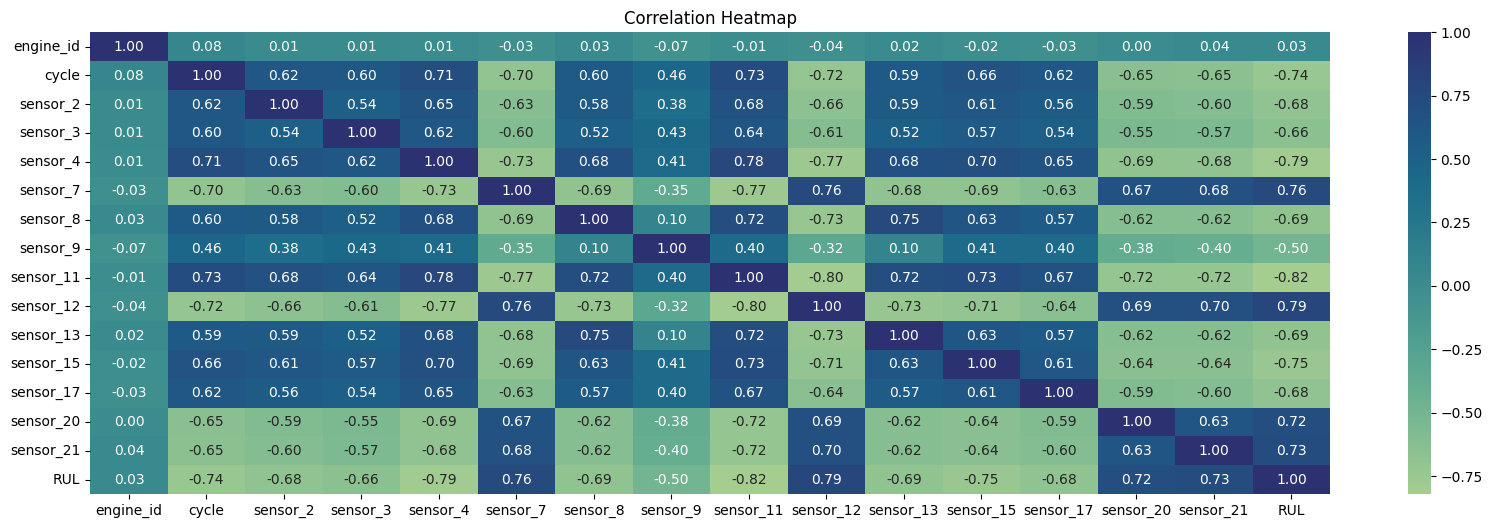

In [ ]:
# Plotting correlation heatmap to check linear correlations
plt.figure(figsize=(20, 6))
sns.heatmap(train_data_FD001.iloc[:,5:].corr(), annot=True, cmap='crest', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Dropping columns
train_data_FD001.drop(columns=['sensor_14', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'], inplace=True)
test_data_FD001.drop(columns=['sensor_14', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'], inplace=True)

Sensor_14_normalized was dropped due to high multi-collinearity.

In [ ]:
# Creating an upper limit threshold for actual RUL to avoid over-prediction
train_data_FD001['RUL'].clip(upper=math.floor(max_cycle['max_cycle'].min()*0.95), inplace=True)

<ipython-input-24-fd546e14cac2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data_FD001['RUL'].clip(upper=math.floor(max_cycle['max_cycle'].min()*0.95), inplace=True)


In [ ]:
train_data_FD001

,engine_id,cycle,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,0.999407,1.001252,0.999829,1.000476,1.000005,0.999628,1.004189,0.999069,0.999990,1.001321,1.000510,1.001950,1.001257,121
1,1,2,0.999921,1.002587,1.001642,0.999376,0.999996,0.999393,1.004612,1.000257,1.000011,1.002784,1.000510,1.000410,1.001454,121
2,1,3,1.000232,1.000175,1.002399,1.000296,1.000013,1.000373,0.999958,1.000525,0.999994,1.001119,0.995406,0.999128,0.998059,121
3,1,4,1.000232,0.996900,1.000735,1.000639,1.000026,0.999991,0.996996,1.001367,1.000015,0.995220,1.000510,0.997332,0.999329,121
4,1,5,1.000263,0.996938,1.003841,0.999827,1.000005,1.000618,1.000169,1.000084,0.999998,1.002499,1.003063,0.997845,1.000633,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,1.001608,1.005432,1.019137,0.995523,1.000054,1.000732,1.014007,0.995424,1.000080,1.009168,1.011723,0.988063,0.985451,4
20627,100,197,1.001686,1.009534,1.022668,0.994494,1.000070,1.000686,1.013374,0.995788,1.000063,1.011342,1.006626,0.983186,0.993425,3
20628,100,198,1.001499,1.008251,1.018816,0.994638,1.000075,1.000773,1.014429,0.996421,1.000072,1.017364,1.014271,0.986780,0.983727,2
20629,100,199,1.001203,1.010012,1.017639,0.994169,1.000079,1.001637,1.020757,0.995769,1.000067,1.014311,1.006626,0.982929,0.989333,1


# 4. Model Training and Testing

In [ ]:
# Splitting the train data into train and validation sets based on engine cycles
engine_ids = train_data_FD001['engine_id'].unique()
train_ids, val_ids = train_test_split(engine_ids, test_size=0.2, random_state=42)

X_train = train_data_FD001[train_data_FD001['engine_id'].isin(train_ids)].iloc[:, 1:-1]
y_train = train_data_FD001[train_data_FD001['engine_id'].isin(train_ids)]['RUL']

X_val = train_data_FD001[train_data_FD001['engine_id'].isin(val_ids)].iloc[:, 1:-1]
y_val = train_data_FD001[train_data_FD001['engine_id'].isin(val_ids)]['RUL']

Splitting the train data based on "engine_id" i.e. full engine cycles ensures that there is no data leakage between the train set and the validation set.

In [ ]:
X_train

,cycle,sensor_2_normalized,sensor_3_normalized,sensor_4_normalized,sensor_7_normalized,sensor_8_normalized,sensor_9_normalized,sensor_11_normalized,sensor_12_normalized,sensor_13_normalized,sensor_15_normalized,sensor_17_normalized,sensor_20_normalized,sensor_21_normalized
192,1,1.000059,0.999511,0.996288,0.999585,0.999998,0.999974,0.995461,0.999776,1.000032,0.999808,1.000000,0.995806,0.999753
193,2,0.999950,1.001537,0.997613,1.000018,0.999985,0.999598,1.002036,1.000484,0.999998,1.002930,1.002558,0.998875,0.997622
194,3,0.999529,1.002338,1.001787,1.000685,1.000010,0.999921,1.001612,1.000255,1.000003,0.998581,1.000000,1.000153,0.998325
195,4,0.999732,0.999707,0.999725,0.999081,0.999985,1.000337,0.999067,1.000082,0.999977,1.001155,1.000000,1.000665,1.001637
196,5,0.999810,0.996475,1.004337,1.000649,1.000006,1.000353,1.002248,0.999661,0.999982,0.999355,0.997442,1.001944,0.998257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,1.001608,1.005432,1.019137,0.995523,1.000054,1.000732,1.014007,0.995424,1.000080,1.009168,1.011723,0.988063,0.985451
20627,197,1.001686,1.009534,1.022668,0.994494,1.000070,1.000686,1.013374,0.995788,1.000063,1.011342,1.006626,0.983186,0.993425
20628,198,1.001499,1.008251,1.018816,0.994638,1.000075,1.000773,1.014429,0.996421,1.000072,1.017364,1.014271,0.986780,0.983727
20629,199,1.001203,1.010012,1.017639,0.994169,1.000079,1.001637,1.020757,0.995769,1.000067,1.014311,1.006626,0.982929,0.989333


Linear Regression Model

In [ ]:
# Linear Regression model training

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print("Linear Regression Training Metrics:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

Linear Regression Training Metrics:
MSE: 304.3422780445287
RMSE: 17.445408508960995
MAE: 13.933063184297863
R2 Score: 0.811759604823753


In [ ]:
# Linear Regression model validation
y_val_pred = lr_model.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("Linear Regression Validation Metrics:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

Linear Regression Validation Metrics:
MSE: 333.98098582185514
RMSE: 18.27514667032402
MAE: 14.512265047961646
R2 Score: 0.7941387163542174


LSTM Model

In [ ]:
import random
# Step 1: Set seeds for reproducibility
seed = 50 # For reproducibility of the results
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
# Reshaping input data for LSTM (samples, timesteps, features)
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_reshaped = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])

# Defining the model
def build_model(hp):
    model = Sequential()
    # Tuning the number of LSTM units
    model.add(LSTM(hp.Int('units', min_value=32, max_value=256, step=32),
                   activation='relu', return_sequences = True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

    # Additional LSTM layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(hp.Int(f'units_{i+2}', min_value=32, max_value=128, step=32),
                       activation='relu', return_sequences=True))

    # Final LSTM layer
    model.add(LSTM(hp.Int('units_final', min_value=32, max_value=128, step=32),
                   activation='relu', return_sequences=False))


    model.add(Dense(1))

    # Tuning the learning rate
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])),
                  loss='mse')

    return model

# Setting up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # Optimizing for validation loss
    max_trials=5,         # Number of different combinations to try
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='lstm_tuning'
)

# Performing hyperparameter search
tuner.search(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val), verbose=1)

# Retrieving the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# Training the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val), verbose=1)

# Evaluating the model
predictions = best_model.predict(X_val_reshaped)
predictions = predictions.reshape(-1)
mse = mean_squared_error(y_val, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, predictions)
r2 = r2_score(y_val, predictions)

print("LSTM Validation Metrics:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

Reloading Tuner from hyperparam_tuning/lstm_tuning/tuner0.json
Best hyperparameters: {'units': 192, 'num_layers': 3, 'units_2': 128, 'units_final': 32, 'learning_rate': 0.001, 'units_3': 32, 'units_4': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 3296.6111 - val_loss: 659.5970
Epoch 2/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 697.7009 - val_loss: 655.6845
Epoch 3/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 695.0991 - val_loss: 657.3197
Epoch 4/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 694.3062 - val_loss: 657.7184
Epoch 5/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 693.9910 - val_loss: 659.3608
Epoch 6/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 694.4487 - val_loss: 661.3060
Epoch 7/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 693.5801 - val_loss: 661.8552
Epoch 8/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 693.2262 - val_loss: 661.9461
Epoch 9/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 693.0900 - val_loss: 661.2970
Epoch 10/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 692.8186 - val_loss: 660.8802
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
LSTM Validation Metrics:
MSE: 660.880214465605

XGBoost Model

In [ ]:
# XGBoost Regressor model training with validation set
!pip install xgboost

tscv = TimeSeriesSplit(n_splits=5)

# Parameter Grid for hyperparameter optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.15]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

# Predicting on the validation set
y_val_pred = grid_search.predict(X_val)

# Computing metrics
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("XGBoost Validation Metrics:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
XGBoost Validation Metrics:
MSE: 209.05511900472354
RMSE: 14.458738499769733
MAE: 10.135101786995403
R2 Score: 0.8711413015171177


The XGBoost model produces the best performance out of all. Hence, it is chosen for computing Feature Importances and further evaluating the test data.

Feature Importances

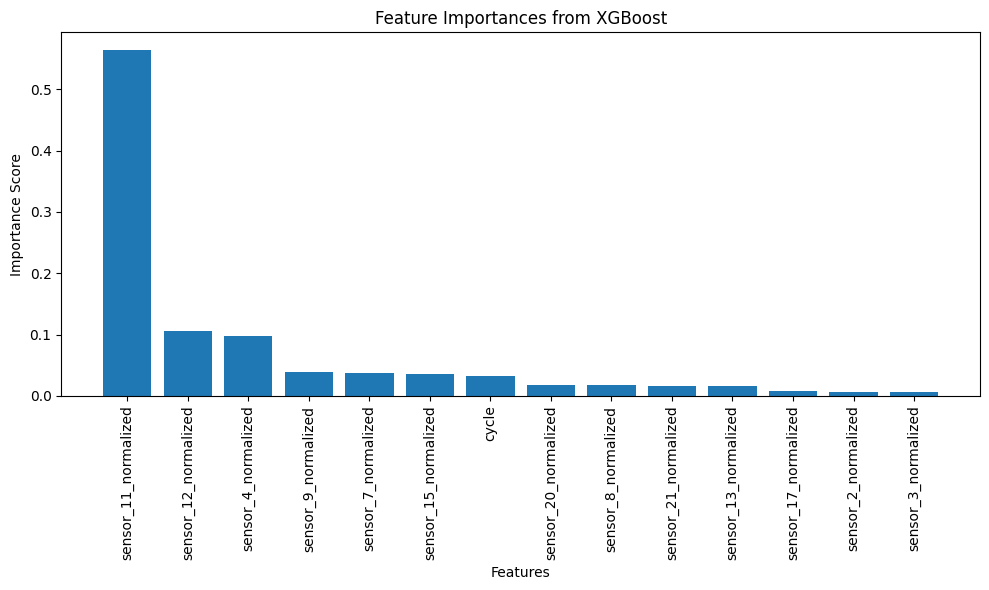

In [ ]:
# Extracting feature names
feature_names = X_train.columns

# Getting feature importances
importances = grid_search.best_estimator_.feature_importances_

# Sorting the features by importance
sorted_idx = np.argsort(importances)[::-1]

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
plt.title("Feature Importances from XGBoost")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

SHAP value plot

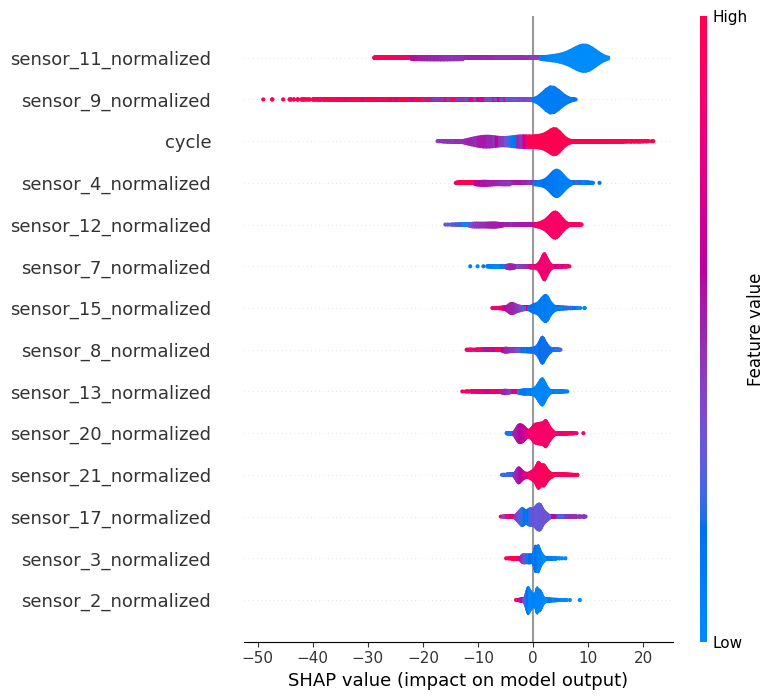

In [ ]:
# Computing SHAP values
explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_train)

# Plotting summary plot
shap.summary_plot(shap_values, X_train, plot_type="violin")

In [ ]:
# Predicting on the test set
y_pred = grid_search.predict(test_data_FD001.iloc[:, 1:])

test_data_FD001['Predicted_RUL_XGBoost'] = y_pred

# Computing metrics
mse = mean_squared_error(rul_data_FD001, test_data_FD001.groupby('engine_id')['Predicted_RUL_XGBoost'].last())
rmse = np.sqrt(mse)
mae = mean_absolute_error(rul_data_FD001, test_data_FD001.groupby('engine_id')['Predicted_RUL_XGBoost'].last())
r2 = r2_score(rul_data_FD001, test_data_FD001.groupby('engine_id')['Predicted_RUL_XGBoost'].last())

print("XGBoost Test Metrics:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

MSE: 247.66218570320936
RMSE: 15.737286478399298
MAE: 12.093164296150208
R2 Score: 0.8565831573482969


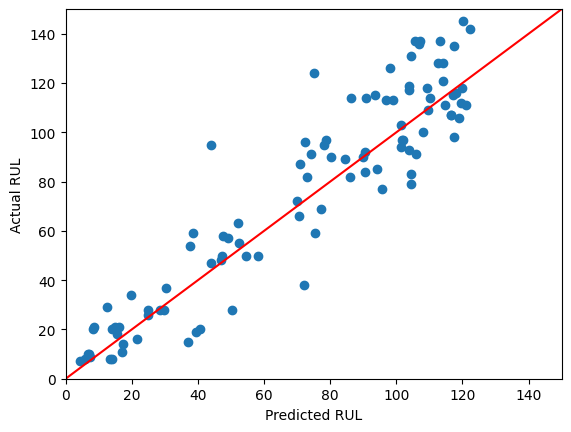

In [ ]:
# Predicted vs Actual scatter plot
plt.figure()
plt.scatter(x=test_data_FD001.groupby('engine_id')['Predicted_RUL_XGBoost'].last(), y=rul_data_FD001)
sns.lineplot(x = [0, 150], y = [0, 150], color = "red")
plt.xlabel("Predicted RUL")
plt.ylabel("Actual RUL")
plt.xlim([0,150])
plt.ylim([0,150])
plt.show()